In [34]:
from __future__ import print_function
from __future__ import division
from collections import defaultdict, OrderedDict
import calendar
import datetime
import dateutil.parser as dparser
from glob import glob
import logging
import matplotlib.pyplot as plt
import matplotlib.path as mplpath
from matplotlib_scalebar.scalebar import ScaleBar
import os
import numpy as np
import pandas as pd
import skimage
import skimage.io as skio
from skimage import draw
import subprocess
import sys
import time
import ujson as json

from optical_vessel_detection.core import img_utils as iutils 
from optical_vessel_detection.core import planet_utils as putils 
from optical_vessel_detection.core.annotation_utils import get_labeled_props

from optical_vessel_detection.support.regions import approximate_simplified_nk_eez
from optical_vessel_detection.support.regions import full_study_area
from optical_vessel_detection.support.regions import reduced_study_area
from optical_vessel_detection.support import notebook_utils
from optical_vessel_detection.support.notebook_utils import path2sceneid, path2datestr
from optical_vessel_detection.support.info import fully_annotated, aois_by_date
from optical_vessel_detection.support import counting_tools
%matplotlib inline

proj_id = os.environ['PROJ_ID']

## Process / Load Info


These instructions are specific to GFW's setup. You will need to adapt this
your specific situation. 

In [35]:
scene_map = notebook_utils.create_scene_map(
    f'{proj_id}.machine_learning_production.planet_scene_info')

detections_map = notebook_utils.create_detections_map(
    f'{proj_id}.machine_learning_production.detected_pair_trawlers_1_1_aug')

Downloading: 100%|██████████| 6920/6920 [00:01<00:00, 5809.44rows/s]


In [36]:
reduced_study_area

array([[129.510458  ,  38.616667  ],
       [131.419292  ,  41.610994  ],
       [132.819292  ,  41.610994  ],
       [134.55790047,  39.8625    ],
       [134.191667  ,  39.8625    ],
       [132.996667  ,  38.616667  ],
       [129.510458  ,  38.616667  ]])

[38.616667 41.610994 41.610994 39.8625   39.8625   38.616667 38.616667]
[38.616667 41.610994 41.610994 39.8625   39.8625   38.616667 38.616667]


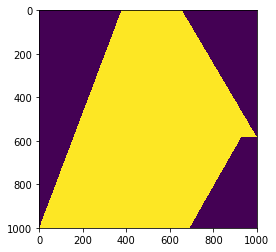

In [37]:
RASTER_SIZE = 1000
valid_mask = np.zeros([RASTER_SIZE, RASTER_SIZE], dtype=bool)
min_lon = min(reduced_study_area[:, 0])
max_lon = max(reduced_study_area[:, 0])
delta_lon = max_lon - min_lon
min_lat = min(reduced_study_area[:, 1])
max_lat = max(reduced_study_area[:, 1])
delta_lat = max_lat - min_lat

def lat2r(x):
    x = np.asarray(x)
    return (RASTER_SIZE - 1) * (max_lat - x) / delta_lat
def r2lat(x):
    x = np.asarray(x)
    return max_lat - delta_lat * x / (RASTER_SIZE - 1)
def lon2c(x):
    x = np.asarray(x)
    return (RASTER_SIZE - 1) * (x - min_lon) / delta_lon


reduced_study_area_r = lat2r(reduced_study_area[:, 1]) 
reduced_study_area_c = lon2c(reduced_study_area[:, 0])

rr, cc = draw.polygon(reduced_study_area_r, reduced_study_area_c, valid_mask.shape)
valid_mask[rr, cc] = 1
plt.imshow(valid_mask)

print(reduced_study_area[:, 1])
print(r2lat(lat2r(reduced_study_area[:, 1])))

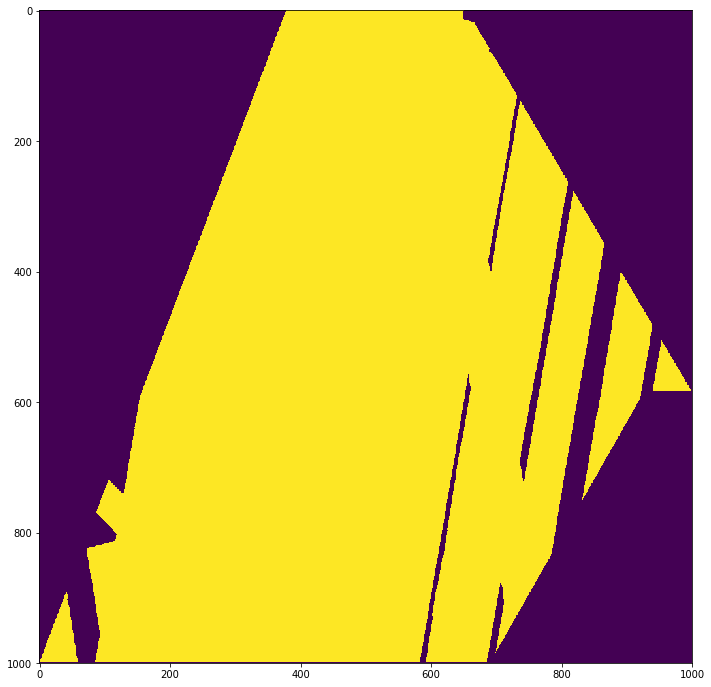

In [38]:
def make_scene_mask(datestr):
    scene_mask = np.zeros_like(valid_mask)
    scenes = [v for (k, v) in scene_map.items() if k.startswith(datestr)]
    for scene in scenes:
        bounds = json.loads(scene.boundary)
        lons = [y['lon'] for y in bounds]
        lats = [y['lat'] for y in bounds]
        rr, cc = draw.polygon(lat2r(lats), lon2c(lons), valid_mask.shape)
        scene_mask[rr, cc] = 1
    return scene_mask
    
    
mask = make_scene_mask('20171024')
plt.figure(figsize=(12, 12))
plt.imshow(mask & valid_mask)

In [39]:
def mask_area(mask):
    area = 0
    for i, row in enumerate(mask):
        scale = np.cos(np.radians(r2lat(i)))
        area += scale * row.sum()
    return area


valid_area = mask_area(valid_mask)
print(valid_area)
print(mask_area(mask & valid_mask) / valid_area)

482517.65437918797
0.9438406734454725


## Plot Detections on Selected Days

The plot code also determines scenes in AOIs and counts 
trawlers. 

In [40]:
skip_dates = ['20180917', '20180929']
dates =  sorted([x for x in detections_map if x not in skip_dates])

In [41]:
ratios = []
for date in dates:
    mask = make_scene_mask(date)
    ratio = mask_area(mask & valid_mask) / valid_area
    print('Coverage fraction for', date, 'is {:.2f}'.format(ratio))
    ratios.append(ratio)
print("Average coverage is {:.2f}".format(np.mean(ratios)))

Coverage fraction for 20170528 is 0.52
Coverage fraction for 20170627 is 0.62
Coverage fraction for 20170715 is 0.84
Coverage fraction for 20170806 is 0.42
Coverage fraction for 20170908 is 0.83
Coverage fraction for 20170926 is 0.78
Coverage fraction for 20171024 is 0.94
Coverage fraction for 20171105 is 0.85
Coverage fraction for 20180421 is 0.70
Coverage fraction for 20180514 is 0.43
Coverage fraction for 20180522 is 0.48
Coverage fraction for 20180602 is 0.49
Coverage fraction for 20180622 is 0.49
Coverage fraction for 20180715 is 0.42
Coverage fraction for 20180731 is 0.66
Coverage fraction for 20180814 is 0.62
Coverage fraction for 20180826 is 0.79
Coverage fraction for 20180911 is 0.92
Coverage fraction for 20180927 is 0.70
Coverage fraction for 20181008 is 0.75
Coverage fraction for 20181102 is 0.81
Coverage fraction for 20181115 is 0.68
Average coverage is 0.67


In [42]:
coverage_ratio_map = {d : r for (d, r) in zip(dates, ratios)}
coverage_ratio_map

{'20170528': 0.5210641847298884,
 '20170627': 0.6183260838663743,
 '20170715': 0.8396126860449078,
 '20170806': 0.4223580290771403,
 '20170908': 0.8332248146391866,
 '20170926': 0.7778519796260764,
 '20171024': 0.9438406734454725,
 '20171105': 0.8508394225024478,
 '20180421': 0.6986587183723794,
 '20180514': 0.43473525847885897,
 '20180522': 0.48388633238800666,
 '20180602': 0.49375265654574724,
 '20180622': 0.4894118638827876,
 '20180715': 0.4191804107960002,
 '20180731': 0.6580150401027633,
 '20180814': 0.617136363125306,
 '20180826': 0.7897580379019252,
 '20180911': 0.9195351282667044,
 '20180927': 0.6985114595033236,
 '20181008': 0.7476910434337778,
 '20181102': 0.8053111881364282,
 '20181115': 0.6753961931848975}

In [43]:
print("Min coverage", min(ratios))
print("Max coverage", max(ratios))

Min coverage 0.4191804107960002
Max coverage 0.9438406734454725
